In [68]:
pwd%

u'/mnt/disk0/home/zhongrunxing/jupyter_code/automl_777/stack_master'

In [69]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sbs

import os
import sys
import gc
import datetime
import time

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")

In [70]:
path = '/home/zhongrunxing/data/kaggle/give_me/'

In [71]:
col_id_label = pd.read_csv(path + 'sample_submission.csv', nrows = 0)
col_id = col_id_label.columns[0]
col_label = col_id_label.columns[1]

In [72]:
# read data
#n_rows = 10000
n_rows = None
train = pd.read_csv(path + 'train.csv', nrows = n_rows)
test = pd.read_csv(path + 'test.csv', nrows = n_rows)
print('train shape = ', train.shape)
print('test shape = ', test.shape)

('train shape = ', (150000, 12))
('test shape = ', (101503, 12))


In [73]:
# prepare data
test_id = test[col_id]
test.drop([col_id], axis = 1, inplace = True)
train_label = train[col_label]
train.drop([col_label], axis = 1, inplace = True) 

if col_id in train.columns:
    train_id = train[col_id]
    train.drop([col_id], axis = 1, inplace = True)
if col_label in test.columns:
    test.drop([col_label], axis = 1, inplace = True)

n_train = train.shape[0]
train_test = pd.concat([train, test], axis = 0).reset_index(drop = True)

del train, test

In [74]:
col_cat = [col for col in train_test.columns if train_test.dtypes[col] == 'object' and col != col_label]
for col in col_cat:
    le = LabelEncoder()
    train_test[col] = le.fit_transform(train_test[col])

In [75]:
train_fea = train_test[:n_train].reset_index(drop = True)
test_fea = train_test[n_train:].reset_index(drop = True)
del train_test

In [9]:
if not os.path.exists(path + '/meta/'):
    os.mkdir(path + '/meta/')
if not os.path.exists(path + '/meta/_id_label/'):
    os.mkdir(path + '/meta/_id_label/')
test_id.to_csv(path + '/meta/_id_label/test_id.csv', index = False, header = col_id)
train_label.to_csv(path + '/meta/_id_label/train_label.csv', index = False, header = col_label)

# params list

In [10]:
params_list_lgb = []
np.random.seed(777)
for i in range(5):
    params = {
            'learning_rate': np.random.choice([0.001, 0.005, 0.01, 0.05, 0.1, 0.2]),
            'num_leaves': np.random.choice([20, 31, 63, 100, 127, 200, 255, 300, 511]),
    #         'min_data': np.random.choice([300, 400, 450, 500, 550, 650]),
    #         'max_bin': np.random.choice([3, 5, 10, 12, 18, 20, 22]),
    #         'min_data_in_leaf':
            'max_depth': np.random.choice([5, 6, 7, 8, 9]),     
            'max_bin': np.random.choice([63, 127, 255, 511]),

            'bagging_freq': np.random.choice([3,5,7]),
            'bagging_fraction': np.random.choice([0.6, 0.7, 0.8, 0.9]),
            'feature_fraction': np.random.choice([0.6, 0.7, 0.8, 0.9]),
    #         'lambda_l1':
    #         'lambda_l2':

            'seed': i,
            'task':'train', 
            'boosting_type' : 'gbdt',
            'objective': 'binary', 
            'metric': 'auc',
            'num_threads': 31
    }
    params_list_lgb.append(params)

In [11]:
params_list_rf = []
np.random.seed(777)
for i in range(5):
    params = {
        'max_depth': np.random.choice([5, 6, 7, 8, 9, 10]),     
        'n_estimators': np.random.choice([500, 600, 700, 800, 900, 1000]),     
        'min_samples_leaf': np.random.choice([5, 10, 20, 30]),
        #'min_samples_split': np.random.choice([10, 20, 30, 40, 50, 100]), 
        #"max_leaf_nodes": np.random.choice([10,20,30,40,50]),
        #"min_weight_fraction_leaf": np.random.choice([0,0.01,0.05,0,1,0.2,0.3]),
        'criterion': np.random.choice(['gini','entropy']),
        'bootstrap': np.random.choice(['False','True']),
        'random_state': i,
        'n_jobs': 31,
    }

    params_list_rf.append(params)

In [12]:
params_list_erf = []
np.random.seed(777)
for i in range(5):
    params = {
        'max_depth': np.random.choice([5, 6, 7, 8, 9, 10, 15, 20, 30]),     
        'n_estimators': np.random.choice([500, 600, 700, 800, 900, 1000]),     
        'min_samples_leaf': np.random.choice([5, 10, 20, 30]),
        'criterion': np.random.choice(['gini','entropy']),
        'bootstrap': np.random.choice(['False','True']),
        'random_state': i,
        'n_jobs': 31,
    }

    params_list_erf.append(params)

In [13]:
params_list_lr = []
np.random.seed(777)
for i in range(5):
    params = {
        'penalty': np.random.choice(['l1', 'l2']),
        'C': np.random.choice([0, 0.25, 0.5, 1, 2, 3, 4, 5]),
        'n_jobs':31
    }

    params_list_lr.append(params)

# generate meta feature

In [67]:
############################## lgb ##############################
def train_lgb(X_train, y_train, X_valid, y_valid, params):
    dtrain = lgb.Dataset(X_train, y_train) 
    dvalid = lgb.Dataset(X_valid, y_valid, reference = dtrain)   
    model = lgb.train(params, 
                      dtrain, 
                      num_boost_round=3000,
                      valid_sets = [dtrain, dvalid],
                      verbose_eval = 0, 
                      early_stopping_rounds = 100)  
    return model

def predict_lgb(model, X):
    return model.predict(X, model.best_iteration)


############################## rf ##############################
def train_rf(X_train, y_train, X_valid, y_valid, params):
    X_train = X_train.fillna(X_train.mean())
    X_valid = X_valid.fillna(X_valid.mean())
    
    model = RandomForestClassifier()
    model.set_params(**params)
    model.fit(X_train, y_train)
    return model

def predict_rf(model, X):
    X = X.fillna(X.mean())
    return model.predict_proba(X)[:,1] 


############################## erf ##############################
def train_erf(X_train, y_train, X_valid, y_valid, params):
    X_train = X_train.fillna(X_train.mean())
    X_valid = X_valid.fillna(X_valid.mean())
    model = ExtraTreesClassifier()    
    model.set_params(**params)
    model.fit(X_train, y_train)
    return model

def predict_erf(model, X):
    X = X.fillna(X.mean())
    return model.predict_proba(X)[:,1]

############################## lr ##############################
def train_lr(X_train, y_train, X_valid, y_valid, params):
    X_train = X_train.fillna(X_train.mean())
    X_valid = X_valid.fillna(X_valid.mean())
    
    model = LogisticRegression()    
    model.set_params(**params)
    model.fit(X_train, y_train)
    return model

def predict_lr(model, X):
    X = X.fillna(X.mean())
    return model.predict_proba(X)[:,1]


############################## generate_meta ##############################
def get_score(y_real, y_pred):
    return roc_auc_score(y_real, y_pred)

def generate_meta(train_fea, test_fea, train_label, model_name, params): 
    n_kfold = 5
    seed_kfold = 777
    
    best_it = []
    score_train_list = []
    score_valid_list = []
    meta_train = np.zeros(len(train_fea))
    meta_test = np.zeros(len(test_fea))

    print('cur time = ' + str(datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    skf = StratifiedKFold(train_label, n_folds=n_kfold, shuffle = True, random_state = seed_kfold)
    for i,(train_idx,valid_idx) in enumerate(skf):
        X_train, y_train = train_fea.iloc[train_idx], train_label.iloc[train_idx]
        X_valid, y_valid = train_fea.iloc[valid_idx], train_label.iloc[valid_idx]
        X_test = test_fea.copy()

        if model_name == 'rf':
            model = train_rf(X_train, y_train, X_valid, y_valid, params)
            y_train_pred = predict_rf(model, X_train)
            y_valid_pred = predict_rf(model, X_valid)
            y_test_pred = predict_rf(model, X_test)
        elif model_name == 'erf':
            model = train_erf(X_train, y_train, X_valid, y_valid, params)
            y_train_pred = predict_erf(model, X_train)
            y_valid_pred = predict_erf(model, X_valid)
            y_test_pred = predict_erf(model, X_test)
        elif model_name == 'lr':
            for col in X_train.columns:
                X_mean = X_train[col].mean()
                X_std = X_train[col].std()
#                 X_mean = 0
#                 X_std = 1
#                 print('col = ', col, 'min = ', X_min, 'max = ', X_max)
                X_train[col] = X_train[col].apply(lambda x: (x - X_mean) / (X_std))
                X_valid[col] = X_valid[col].apply(lambda x: (x - X_mean) / (X_std))
                X_test[col] = X_test[col].apply(lambda x: (x - X_mean) / (X_std))
            
            model = train_lr(X_train, y_train, X_valid, y_valid, params)
            y_train_pred = predict_lr(model, X_train)
            y_valid_pred = predict_lr(model, X_valid)
            y_test_pred = predict_lr(model, X_test)
        elif model_name == 'lgb':
            model = train_lgb(X_train, y_train, X_valid, y_valid, params)
            y_train_pred = predict_lgb(model, X_train)
            y_valid_pred = predict_lgb(model, X_valid)
            y_test_pred = predict_lgb(model, X_test)
        else:
            model = train_lgb(X_train, y_train, X_valid, y_valid, params)
            y_train_pred = predict_lgb(model, X_train)
            y_valid_pred = predict_lgb(model, X_valid)
            y_test_pred = predict_lgb(model, X_test)
    
        #best_it.append(model.best_iteration)
        score_train_list.append(get_score(y_train, y_train_pred))
        score_valid_list.append(get_score(y_valid, y_valid_pred))

        meta_train[valid_idx] += y_valid_pred
        meta_test += y_test_pred
        gc.collect()
        
    print('cur time = ' + str(datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    print("whole valid auc = " + str(roc_auc_score(train_label, meta_train)))
    #print('best_iteration', best_it, np.mean(best_it))
    print('train', np.array(score_train_list), 'mean = ', np.mean(score_train_list))
    print('valid', np.array(score_valid_list), 'mean = ', np.mean(score_valid_list))
    
    
    meta_test = meta_test / n_kfold
    gc.collect()
    return meta_train, meta_test, np.mean(score_train_list), np.mean(score_valid_list)

In [15]:
def model_X_go(train_fea, test_fea, train_label, model_name, params_list):
    print('######  {}  ######'.format(model_name))
    print(train_fea.shape, test_fea.shape)
    score_train_list = []
    score_valid_list = []
    meta_test_list = []
    for i, params in enumerate(params_list):
        print('\n################################################## seed = ' + str(i)) 
        meta_train, meta_test, score_train, score_valid = \
            generate_meta(train_fea, test_fea, train_label, model_name, params)
            
        score_train_list.append(score_train)
        score_valid_list.append(score_valid)
        meta_test_list.append(meta_test)

        meta_train = pd.DataFrame(meta_train)
        meta_test = pd.DataFrame(meta_test)
        meta_train.to_csv(path + '/meta/' + model_name + '_meta_train_' + str(i)  + '.csv', index = False, header = None)
        meta_test.to_csv(path + '/meta/' + model_name + '_meta_test_' + str(i)  + '.csv', index = False, header = None)
        del meta_train, meta_test

    print('###### result ######')
    print('score train mean = {}'.format(np.mean(score_train_list)))
    print('score valid mean = {}'.format(np.mean(score_valid_list)))
    if not os.path.exists(path + '/meta/_result_raw/'):
        os.mkdir(path + '/meta/_result_raw/')
    result = pd.DataFrame({col_id:test_id, col_label:np.mean(meta_test_list, axis = 0)})[[col_id, col_label]]
    result.to_csv(path + '/meta/_result_raw/baseline_{}_raw_X.csv'.format(model_name), index = False)

In [16]:
model_X_go(train_fea, test_fea, train_label, 'lgb', params_list_lgb)

######  lgb  ######
((150000, 10), (101503, 10))

################################################## seed = 0
cur time = 2018/12/05 15:56:02
cur time = 2018/12/05 15:56:21
whole valid auc = 0.8652054549579498
('train', array([0.88450091, 0.88346788, 0.88064294, 0.89394512, 0.87861014]), 'mean = ', 0.8842334010471392)
('valid', array([0.85924227, 0.86726341, 0.86860615, 0.86284764, 0.87090268]), 'mean = ', 0.8657724296958458)

################################################## seed = 1
cur time = 2018/12/05 15:56:22
cur time = 2018/12/05 15:57:57
whole valid auc = 0.8648179852334777
('train', array([0.89084249, 0.88929739, 0.88918988, 0.89970685, 0.88502991]), 'mean = ', 0.8908133055296888)
('valid', array([0.85804862, 0.86665957, 0.86801701, 0.86261184, 0.87099293]), 'mean = ', 0.8652659929735801)

################################################## seed = 2
cur time = 2018/12/05 15:57:57
cur time = 2018/12/05 15:59:40
whole valid auc = 0.8654044417858332
('train', array([0.8961625 , 0.

In [17]:
model_X_go(train_fea, test_fea, train_label, 'rf', params_list_rf)

######  rf  ######
((150000, 10), (101503, 10))

################################################## seed = 0
cur time = 2018/12/05 16:01:40
cur time = 2018/12/05 16:02:36
whole valid auc = 0.8631676719786133
('train', array([0.87464307, 0.87257003, 0.87251396, 0.87382427, 0.87153397]), 'mean = ', 0.8730170613337365)
('valid', array([0.85633854, 0.86486295, 0.86608192, 0.85967131, 0.86967792]), 'mean = ', 0.8633265256462863)

################################################## seed = 1
cur time = 2018/12/05 16:02:36
cur time = 2018/12/05 16:03:28
whole valid auc = 0.8637779620729256
('train', array([0.87854601, 0.87623776, 0.87635001, 0.87756914, 0.87560448]), 'mean = ', 0.8768614800441392)
('valid', array([0.85711396, 0.86533877, 0.86720406, 0.85990787, 0.87009356]), 'mean = ', 0.8639316412747213)

################################################## seed = 2
cur time = 2018/12/05 16:03:29
cur time = 2018/12/05 16:04:44
whole valid auc = 0.8616281676813419
('train', array([0.86953536, 0.8

In [18]:
model_X_go(train_fea, test_fea, train_label, 'erf', params_list_erf)

######  erf  ######
((150000, 10), (101503, 10))

################################################## seed = 0
cur time = 2018/12/05 16:06:41
cur time = 2018/12/05 16:07:32
whole valid auc = 0.8341599459106753
('train', array([0.84106938, 0.83839266, 0.83870531, 0.83975138, 0.83764944]), 'mean = ', 0.8391136360852345)
('valid', array([0.82285052, 0.84092955, 0.83666516, 0.83255438, 0.83800329]), 'mean = ', 0.8342005799795811)

################################################## seed = 1
cur time = 2018/12/05 16:07:33
cur time = 2018/12/05 16:08:35
whole valid auc = 0.8326805800225683
('train', array([0.83831299, 0.83526144, 0.83573529, 0.83689817, 0.83493937]), 'mean = ', 0.8362294538285383)
('valid', array([0.8214481 , 0.83952287, 0.83492334, 0.83104098, 0.83649741]), 'mean = ', 0.832686539545492)

################################################## seed = 2
cur time = 2018/12/05 16:08:35
cur time = 2018/12/05 16:09:22
whole valid auc = 0.8400748146550291
('train', array([0.85688863, 0.8

In [19]:
model_X_go(train_fea, test_fea, train_label, 'lr', params_list_lr)

######  lr  ######
((150000, 10), (101503, 10))

################################################## seed = 0
cur time = 2018/12/05 16:10:56
cur time = 2018/12/05 16:11:09
whole valid auc = 0.6953592797837173
('train', array([0.696176  , 0.69594442, 0.69579739, 0.69975614, 0.69088308]), 'mean = ', 0.6957114048040165)
('valid', array([0.69256433, 0.70189791, 0.70349043, 0.68236462, 0.69316751]), 'mean = ', 0.6946969581310721)

################################################## seed = 1
cur time = 2018/12/05 16:11:10
cur time = 2018/12/05 16:11:24
whole valid auc = 0.6957809711895114
('train', array([0.69602688, 0.69618249, 0.69658327, 0.70075306, 0.69088196]), 'mean = ', 0.6960855315164958)
('valid', array([0.69253516, 0.70197801, 0.70397076, 0.68337061, 0.69316612]), 'mean = ', 0.6950041302392517)

################################################## seed = 2
cur time = 2018/12/05 16:11:25
cur time = 2018/12/05 16:11:38
whole valid auc = 0.6963278454286249
('train', array([0.69809465, 0.6

# stacking master

## load col_id and col_label

In [22]:
train_label = pd.read_csv(path + '/meta/_id_label/train_label.csv')
col_label = train_label.columns[0]
train_label = train_label[col_label]

test_id = pd.read_csv(path + '/meta/_id_label/test_id.csv')
col_id = test_id.columns[0]
test_id = test_id[col_id]

In [23]:
print('col_id = ', col_id, 'col_label = ', col_label)

('col_id = ', 'Id', 'col_label = ', 'Probability')


## load meta feature

In [47]:
meta_train_fea = pd.DataFrame([])
meta_test_fea = pd.DataFrame([])
for name in os.listdir(path + 'meta'):
    if 'csv' not in name or 'test' in name:
        continue
        
    path_train = path + 'meta/' + name
    path_test = path + 'meta/' + name.replace('train', 'test')
    meta_train_i = pd.read_csv(path_train, header = None)
    meta_test_i = pd.read_csv(path_test, header = None)
    meta_train_i.columns = [name.replace('.csv', '').replace('_train', '')]
    meta_test_i.columns = [name.replace('.csv', '').replace('_train', '')]
    
    meta_train_fea = pd.concat([meta_train_fea, meta_train_i], axis = 1)
    meta_test_fea = pd.concat([meta_test_fea, meta_test_i], axis = 1)

print(meta_train_fea.shape, meta_test_fea.shape)

((150000, 20), (101503, 20))


## add origin X

In [48]:
meta_train_fea = pd.concat([meta_train_fea, train_fea], axis = 1)
meta_test_fea = pd.concat([meta_test_fea, test_fea], axis = 1)
print(meta_train_fea.shape, meta_test_fea.shape)

((150000, 30), (101503, 30))


In [39]:
# meta_train_fea = pd.concat([train_fea], axis = 1)
# meta_test_fea = pd.concat([test_fea], axis = 1)
# print(meta_train_fea.shape, meta_test_fea.shape)

((150000, 10), (101503, 10))


# feature importance 

In [33]:
def simple_lgb(X, y):
    print('######################################################## begin')
    print('####### cur time = ' + str(datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val)
    
    params = {
        'task':'train', 
        'objective': 'binary',
        'metric': 'auc',

        'boosting_type':'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'subsample':0.85,
        'num_threads': 15,
        'seed': 1,
        'max_bin':127,
        'is_unbalance': True # useful
        #'reg_alpha': 0.1,
        #'reg_lambda': 0.1
    }   
    model = lgb.train(params, train_data, 3000, [train_data, valid_data],
                          early_stopping_rounds=100, verbose_eval=-1)
    print('########################################################## end')
    print('####### cur time = ' + str(datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    return model

In [34]:
model_lgb = simple_lgb(meta_train_fea, train_label)

######################################################## begin
####### cur time = 2018/12/05 16:15:59
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	training's auc: 0.88412	valid_1's auc: 0.864406
########################################################## end
####### cur time = 2018/12/05 16:16:01


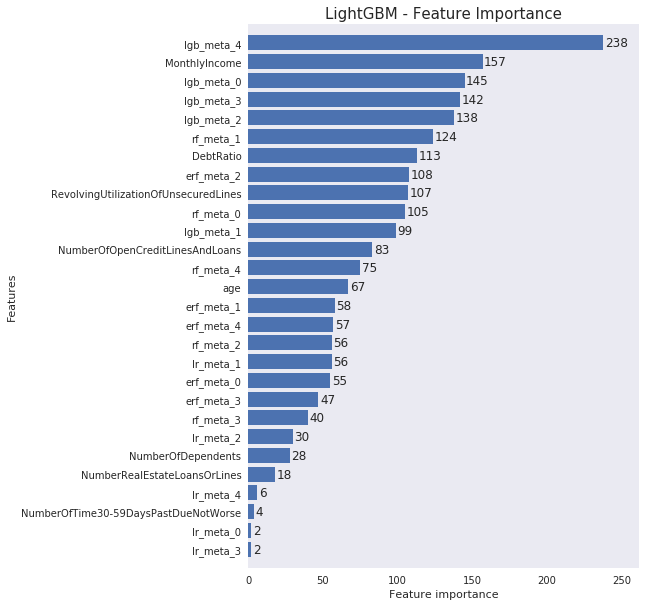

In [36]:
fig, ax = plt.subplots(figsize=(7,10))
lgb.plot_importance(model_lgb, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

# <font color = 'red'> Go Go Go </font>

In [37]:
#############################################################################
##  StratifiedKFold, bagging
#############################################################################
params_default = {
    'task':'train', 
    'objective': 'binary',
    'metric': 'auc', 
    'boosting_type':'gbdt',
    'num_threads': 31,
    
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.85,
    'subsample':0.85,
    'num_threads': 15,
    'seed': 1,
    'max_bin':127,
    'reg_alpha': 1,
    'reg_lambda': 1
}

def cv_lgb(train_fea, test_fea, train_label, n_seed, n_kfold, params = params_default):
    print('train shape = ', train_fea.shape, 'test shape = ', test_fea.shape)
    bagging_best_it = []
    bagging_score_list = []
    bagging_meta_train = np.zeros(len(train_fea))
    bagging_meta_test = np.zeros(len(test_fea))

    seed_list = range(n_seed)
    for si, seed in enumerate(seed_list):
        print('\n################################################## seed = ' + str(seed))
        print('cur time = ' + str(datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
        best_it = []
        score_list = []
        meta_train = np.zeros(len(train_fea))
        meta_test = np.zeros(len(test_fea))
        
        skf = StratifiedKFold(train_label, n_folds=n_kfold, shuffle=True, random_state=seed)
        for i,(train_idx,valid_idx) in enumerate(skf):
            X_train, y_train = train_fea.iloc[train_idx], train_label.iloc[train_idx]
            X_valid, y_valid = train_fea.iloc[valid_idx], train_label.iloc[valid_idx]
            X_test = test_fea

            dtrain = lgb.Dataset(X_train, y_train) 
            dvalid = lgb.Dataset(X_valid, y_valid, reference = dtrain)  
            
    
            params['seed'] = seed
            model = lgb.train(params, 
                              dtrain, 
                              num_boost_round=3000,
                              valid_sets=[dtrain,dvalid],
                              verbose_eval=0, 
                              early_stopping_rounds=100)  

            best_it.append(model.best_iteration)
            score_list.append(model.best_score)
            
            pred_valid = model.predict(X_valid, model.best_iteration)
            pred_test = model.predict(X_test, model.best_iteration)
            meta_train[valid_idx] += pred_valid
            meta_test += pred_test
            gc.collect()
            #print('cur time = ' + str(datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
        
        gc.collect()
        bagging_best_it += best_it
        bagging_score_list += score_list
        bagging_meta_train += meta_train
        bagging_meta_test += (meta_test / n_kfold)
        
        print('========================= seed = ' + str(seed))
        print("current whole valid auc = " + str(roc_auc_score(train_label, meta_train)))
        print("bagging whole valid auc = " + str(roc_auc_score(train_label, bagging_meta_train / (1.0 * (si + 1)))))
        print('best_iteration',best_it, np.mean(best_it))
        train_auc = np.array([i['training']['auc'] for i in score_list])
        valid_auc = np.array([i['valid_1']['auc'] for i in score_list])
        print('train', train_auc, np.mean(train_auc))
        print('valid', valid_auc, np.mean(valid_auc))
    
    
    # really bagging
    bagging_meta_train /= (1.0 * n_seed)
    bagging_meta_test /= (1.0 * n_seed)
    
    # average
    train_auc = np.array([i['training']['auc'] for i in bagging_score_list])
    valid_auc = np.array([i['valid_1']['auc'] for i in bagging_score_list])
    print('\n##############################################')
    print('### CV avergae result ###')
    print('cur time = ' + str(datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    print('train auc = ' + str(train_auc.mean()))
    print('valid auc = ' + str(valid_auc.mean()))
    print('##############################################')
    print("bagging whole valid auc = " + str(roc_auc_score(train_label, bagging_meta_train / (1.0 * (si + 1)))))
   
    gc.collect()
    return bagging_meta_train, bagging_meta_test

In [40]:
# X
bagging_meta_train, bagging_meta_test = cv_lgb(train_fea, test_fea, train_label, 10, 5)

('train shape = ', (150000, 10), 'test shape = ', (101503, 10))

################################################## seed = 0
cur time = 2018/12/05 16:19:09
========================= seed = 0
current whole valid auc = 0.8661363159002904
bagging whole valid auc = 0.8661363159002904
('best_iteration', [219, 154, 170, 280, 156], 195.8)
('train', array([0.88731816, 0.88080383, 0.88339392, 0.89158822, 0.88072042]), 0.8847649096729342)
('valid', array([0.86493372, 0.86913268, 0.86387071, 0.86498482, 0.86854554]), 0.8662934951040541)

################################################## seed = 1
cur time = 2018/12/05 16:19:24
========================= seed = 1
current whole valid auc = 0.8662232503433975
bagging whole valid auc = 0.8666630035088075
('best_iteration', [331, 143, 255, 166, 169], 212.8)
('train', array([0.89321753, 0.88069267, 0.88704214, 0.88185952, 0.88362379]), 0.8852871303913166)
('valid', array([0.86693031, 0.86360938, 0.87075455, 0.86882104, 0.86143518]), 0.8663100917591015)


In [38]:
# X + meta
bagging_meta_train, bagging_meta_test = cv_lgb(meta_train_fea, meta_test_fea, train_label, 10, 5)

('train shape = ', (150000, 30), 'test shape = ', (101503, 30))

################################################## seed = 0
cur time = 2018/12/05 16:16:38
========================= seed = 0
current whole valid auc = 0.8598528582853768
bagging whole valid auc = 0.8598528582853768
('best_iteration', [80, 77, 56, 92, 62], 73.4)
('train', array([0.87603523, 0.87408703, 0.87213294, 0.87735816, 0.87158734]), 0.8742401408279348)
('valid', array([0.8653793 , 0.86909554, 0.86299952, 0.86516464, 0.8675681 ]), 0.8660414196894907)

################################################## seed = 1
cur time = 2018/12/05 16:16:48
========================= seed = 1
current whole valid auc = 0.8568098278466585
bagging whole valid auc = 0.8607367112670958
('best_iteration', [70, 75, 94, 51, 99], 77.8)
('train', array([0.87327791, 0.87520235, 0.87718917, 0.86993745, 0.88060446]), 0.8752422700400653)
('valid', array([0.86668251, 0.86484888, 0.86997096, 0.86827676, 0.85971528]), 0.8658988782810579)

###########

# hyperopt 

In [44]:
import hyperopt
from hyperopt import hp, tpe, STATUS_OK, space_eval, Trials

config = {}
#config['mode'] = 'regression'
config['mode'] = 'classification'
params = {
        "objective": "regression" if config["mode"] == "regression" else "binary",
        "metric": "rmse" if config["mode"] == "regression" else "auc",
        "verbosity": -1,
        "seed": 1,
        "num_threads": 31,
}

def merge_dict(d1, d2):
    tmp = d1.copy()
    tmp.update(d2)
    return tmp
def hyperopt_lightgbm(X, y, params, config):
    print('######################################################## begin hyperopt_lightgbm')
    print('####### cur time = ' + str(datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
     
    space = {
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.05),
        "max_depth": hp.choice("max_depth", [-1]),
        "num_leaves": hp.choice("num_leaves", np.linspace(10, 200, 50, dtype=int)),
        "feature_fraction": hp.quniform("feature_fraction", 0.5, 1.0, 0.1),
        "bagging_fraction": hp.quniform("bagging_fraction", 0.5, 1.0, 0.1),
        "bagging_freq": hp.choice("bagging_freq", np.linspace(0, 50, 10, dtype=int)),
        "reg_alpha": hp.uniform("reg_alpha", 0, 30),
        "reg_lambda": hp.uniform("reg_lambda", 0, 30),
        "min_child_weight": hp.uniform('min_child_weight', 0.5, 10),
    }

    skf = StratifiedKFold(train_label, n_folds=5, shuffle=True, random_state=777)
    def objective(hyperparams):
        score_list = []
        for i,(train_idx,valid_idx) in enumerate(skf):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]
            
            dtrain = lgb.Dataset(X_train, label=y_train)
            dvalid = lgb.Dataset(X_valid, label=y_valid)
    
            model = lgb.train(merge_dict(params, hyperparams), dtrain, 3000, dvalid, 
                              early_stopping_rounds=100, verbose_eval=0)

            score = model.best_score["valid_0"][params["metric"]]
            score_list.append(score)
        
        score = np.mean(score_list)
        if config['mode'] == 'classification':
            score = -score
        return {'loss': score, 'status': STATUS_OK}

    trials = Trials()
    best = hyperopt.fmin(fn=objective, space=space, trials=trials, algo=tpe.suggest, max_evals=50, verbose=1,
                         rstate=np.random.RandomState(1))

    hyperparams = space_eval(space, best)
    print('########################################################## end hyperopt_lightgbm')
    print('####### cur time = ' + str(datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    print("{:0.4f} {}".format(trials.best_trial['result']['loss'], hyperparams))
    #return hyperparams, best, trials, space

    
    ####################################################
    ## result
    def space_eval_trials(space, trials, params_basic):
        params_list = []
        for t in range(len(trials)):
            for_eval = {}
            for k, v in trials[t]["misc"]["vals"].items():
                if len(v) == 0:
                    for_eval[k] = None
                else:
                    for_eval[k] = v[0]

            params = space_eval(space, for_eval)
            params_list.append(merge_dict(params_basic, params))
        return params_list
    
    params_basic = {
        'task':'train', 
        'objective': 'binary',
        'metric': 'auc', 
        'boosting_type':'gbdt'
    }
    hyperopt_result = pd.DataFrame([])
    hyperopt_result['auc'] = pd.DataFrame(trials.trials)['result'].apply(lambda x: -1 * x['loss'])
    hyperopt_result['params'] = space_eval_trials(space, trials.trials, params_basic)

    hyperopt_result['auc'].plot()
    plt.show()
    hyperopt_result = hyperopt_result.sort_values(by = 'auc', ascending=False).reset_index(drop = True)
    return hyperopt_result
    
    

######################################################## begin hyperopt_lightgbm
####### cur time = 2018/12/05 16:24:16
########################################################## end hyperopt_lightgbm
####### cur time = 2018/12/05 16:46:58
-0.8667 {'num_leaves': 17, 'reg_alpha': 10.038196356032481, 'bagging_freq': 44, 'learning_rate': 0.030913570643500435, 'min_child_weight': 7.746872753876168, 'reg_lambda': 20.50672319622874, 'bagging_fraction': 0.9, 'max_depth': -1, 'feature_fraction': 0.6000000000000001}


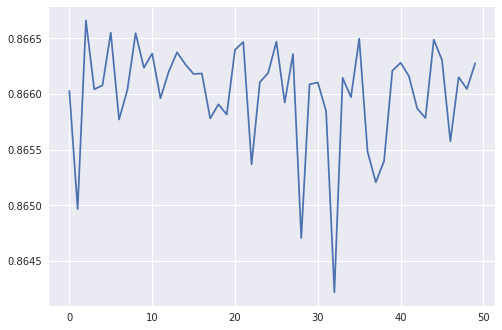

In [43]:
# X
hyperopt_result = hyperopt_lightgbm(train_fea,  train_label, params, config)

In [46]:
hyperopt_result.head()

,auc,params
0,0.866660,"{u'num_leaves': 17, u'reg_alpha': 10.038196356..."
1,0.866551,"{u'num_leaves': 21, u'reg_alpha': 10.785360253..."
2,0.866545,"{u'num_leaves': 33, u'reg_alpha': 22.166382413..."
3,0.866496,"{u'num_leaves': 95, u'reg_alpha': 19.405936061..."
4,0.866488,"{u'num_leaves': 10, u'reg_alpha': 21.554937658..."


((150000, 30), (101503, 30))
######################################################## begin hyperopt_lightgbm
####### cur time = 2018/12/05 16:57:19
########################################################## end hyperopt_lightgbm
####### cur time = 2018/12/05 17:06:03
-0.8663 {'num_leaves': 10, 'reg_alpha': 10.449258407078908, 'bagging_freq': 5, 'learning_rate': 0.03377712188465733, 'min_child_weight': 8.236692931837638, 'reg_lambda': 4.490836188615002, 'bagging_fraction': 0.9, 'max_depth': -1, 'feature_fraction': 0.6000000000000001}


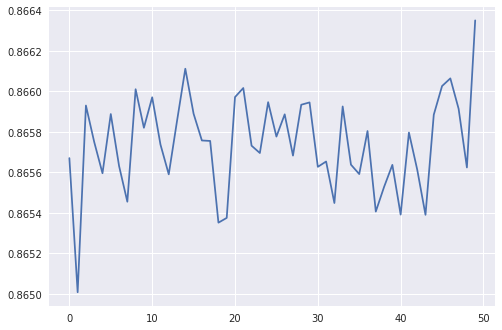

In [50]:
# X + meta
print(meta_train_fea.shape, meta_test_fea.shape)
hyperopt_result_2 = hyperopt_lightgbm(meta_train_fea,  train_label, params, config)

# after hyperopt

In [78]:
## X
# private = 0.868443
# public = 0.861826
params = hyperopt_result['params'][0]
bagging_meta_train, bagging_meta_test = cv_lgb(train_fea, test_fea, train_label, 10, 5, params)

('train shape = ', (150000, 10), 'test shape = ', (101503, 10))

################################################## seed = 0
cur time = 2018/12/05 17:28:40
========================= seed = 0
current whole valid auc = 0.8668319360959889
bagging whole valid auc = 0.8668319360959889
('best_iteration', [617, 878, 538, 498, 565], 619.2)
('train', array([0.87717385, 0.8784865 , 0.87633414, 0.87589546, 0.87594342]), 0.8767666749527123)
('valid', array([0.86517834, 0.86970549, 0.8654667 , 0.86495458, 0.86903774]), 0.8668685715713031)

################################################## seed = 1
cur time = 2018/12/05 17:29:20
========================= seed = 1
current whole valid auc = 0.866587023338531
bagging whole valid auc = 0.8669855823670378
('best_iteration', [389, 440, 485, 482, 586], 476.4)
('train', array([0.8737379 , 0.87491433, 0.8743669 , 0.87465893, 0.87753351]), 0.8750423140621661)
('valid', array([0.86681994, 0.86494643, 0.87081009, 0.86898082, 0.86204152]), 0.8667197580940215)



In [79]:
if not os.path.exists(path + '/meta/_result/'):
    os.mkdir(path + '/meta/_result/')
result = pd.DataFrame({col_id:test_id, col_label:bagging_meta_test})[[col_id, col_label]]
result.to_csv(path + '/meta/_result/stacking_X.csv', index = False)

In [60]:
## X + meta
# private = 0.868659
# public = 0.862403
params = hyperopt_result_2['params'][0]
bagging_meta_train_2, bagging_meta_test_2 = cv_lgb(meta_train_fea, meta_test_fea, train_label, 10, 5, params)

('train shape = ', (150000, 30), 'test shape = ', (101503, 30))

################################################## seed = 0
cur time = 2018/12/05 17:19:54
========================= seed = 0
current whole valid auc = 0.8649957718060267
bagging whole valid auc = 0.8649957718060267
('best_iteration', [150, 196, 238, 149, 128], 172.2)
('train', array([0.86965654, 0.86938724, 0.87171617, 0.86975908, 0.86862844]), 0.8698294939510713)
('valid', array([0.86515333, 0.86926961, 0.86365056, 0.8657203 , 0.86782497]), 0.866323754898238)

################################################## seed = 1
cur time = 2018/12/05 17:20:10
========================= seed = 1
current whole valid auc = 0.8657690167736859
bagging whole valid auc = 0.8655608285846457
('best_iteration', [153, 165, 154, 140, 149], 152.2)
('train', array([0.8692896 , 0.8701563 , 0.86855841, 0.86875118, 0.87110416]), 0.8695719303528412)
('valid', array([0.86675288, 0.86496007, 0.87083382, 0.86866487, 0.8601958 ]), 0.8662814884402424)



In [62]:
if not os.path.exists(path + '/meta/_result/'):
    os.mkdir(path + '/meta/_result/')
result = pd.DataFrame({col_id:test_id, col_label:bagging_meta_test_2})[[col_id, col_label]]
result.to_csv(path + '/meta/_result/stacking_X_meta.csv', index = False)